In [1]:
import pandas as pd
import numpy as np
from toolz.curried import *
import tensorflow as tf
from qrnn.data_preprocess import *
from qrnn.pipeline import pipeline
from qrnn.models import adaptive
from qrnn.evaluation import *

from matplotlib import pyplot as plt
plt.style.use("ggplot")

N_LAGS=1
PRICE_COLS = ["Adjusted Close"]

Using TensorFlow backend.


In [2]:
data  = pd.read_csv('SP500.csv', usecols=['Adjusted Close', 'Date'])
data.head()

,Date,Adjusted Close
0,2016-10-13,2132.550049
1,2016-10-12,2139.179932
2,2016-10-11,2136.729980
3,2016-10-10,2163.659912
4,2016-10-07,2153.739990


In [3]:
differ_learner = diff_log_pricer(price_columns=PRICE_COLS, date_column="Date")
lagger_learner = lagger(n_lags=N_LAGS, price_columns=PRICE_COLS)
na_clearn_learner = clean_nan(how="any")

In [4]:
pre_process_fn = pipeline(learners=[differ_learner, lagger_learner, na_clearn_learner])
processed_data = pre_process_fn(data)

In [5]:
splitter = time_split_dataset(train_start_date="1960-01-01", train_end_date="2010-01-01", holdout_end_date="2016-01-01", date_col="Date")
train, test = splitter(processed_data)
train.head()

,Adjusted Close,Adjusted Close1,Date
2511,0.033391,0.798008,1960-01-04
2512,0.798008,-0.431461,1960-01-05
2513,-0.431461,-0.734442,1960-01-06
2514,-0.734442,-0.318817,1960-01-07
2515,-0.318817,-1.234479,1960-01-08


In [6]:
var_estimator, train_pred = adaptive(train, price_cols="Adjusted Close", target_col="Adjusted Close1",
                                     prediction_col="prediction", tau=0.95)

test_pred = var_estimator(test)

In [7]:
quantile_eval_fn = quantile_loss_evaluator(predict_col="prediction",
                                           target_col="Adjusted Close1",
                                           tau=0.05)

hits_eval_fn = proportion_of_hits_evaluator(predict_col="prediction",
                                            target_col="Adjusted Close1")

In [8]:
print("Quantile loss on train %f and test %f sets" % tuple(map(quantile_eval_fn, [train_pred, test_pred])))
print("Number of hits on train %f and test %f sets" % tuple(map(hits_eval_fn, [train_pred, test_pred])))

Quantile loss on train 0.108029 and test 0.123204 sets
Number of hits on train 0.049261 and test 0.052318 sets


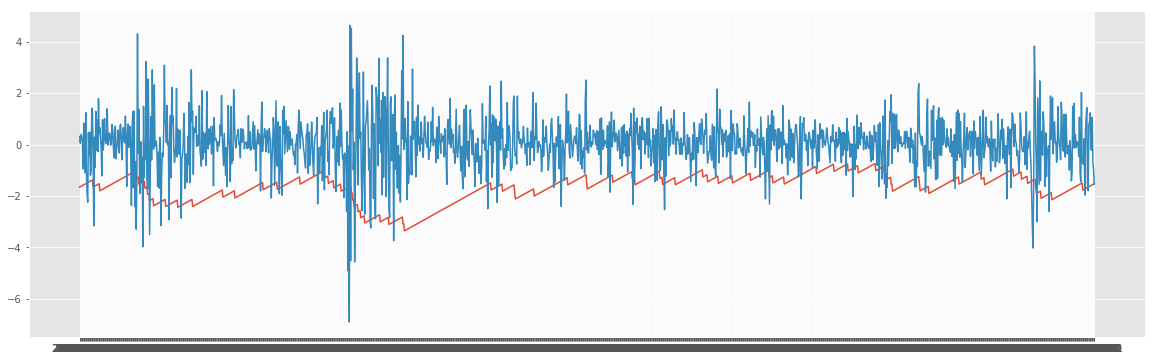

In [9]:
plt.figure(figsize=(20, 6))
plt.plot(test_pred["Date"], test_pred["prediction"])
plt.plot(test_pred["Date"], test_pred["Adjusted Close1"])

In [10]:

data  = (
    pd.read_csv('index.csv', sep=";", skiprows=1, usecols=["Day", "TR GLOBAL"])
    .rename(columns={"Day": "Date"})
    .assign(Date=lambda df: pd.to_datetime(df["Date"], format='%d/%m/%Y'))
)
data.columns

Index(['Date', 'TR GLOBAL'], dtype='object')

In [11]:
PRICE_COLS = ["TR GLOBAL"]
differ_learner = diff_log_pricer(price_columns=PRICE_COLS, date_column="Date")
lagger_learner = lagger(n_lags=N_LAGS, price_columns=PRICE_COLS)
na_clearn_learner = clean_nan(how="any")

pre_process_fn = pipeline(learners=[na_clearn_learner, differ_learner, lagger_learner, na_clearn_learner])
processed_data = pre_process_fn(data)

In [12]:
splitter = time_split_dataset(train_start_date="1960-01-01", train_end_date="2010-01-01", holdout_end_date="2016-01-01", date_col="Date")
train, test = splitter(processed_data)
train.head()

,Date,TR GLOBAL,TR GLOBAL1
1,2000-01-04,-2.896582,-1.767530
2,2000-01-05,-1.767530,-1.022255
3,2000-01-06,-1.022255,1.937617
4,2000-01-07,1.937617,1.299915
5,2000-01-10,1.299915,-0.136984


In [13]:
var_estimator, train_pred = adaptive(train, price_cols="TR GLOBAL", target_col="TR GLOBAL1",
                                     prediction_col="prediction", tau=0.95)

test_pred = var_estimator(test)

In [14]:
quantile_eval_fn = quantile_loss_evaluator(predict_col="prediction",
                                           target_col="TR GLOBAL1",
                                           tau=0.05)

hits_eval_fn = proportion_of_hits_evaluator(predict_col="prediction",
                                            target_col="TR GLOBAL1")

print("Quantile loss on train %f and test %f sets" % tuple(map(quantile_eval_fn, [train_pred, test_pred])))
print("Number of hits on train %f and test %f sets" % tuple(map(hits_eval_fn, [train_pred, test_pred])))

Quantile loss on train 0.114824 and test 0.105819 sets
Number of hits on train 0.062908 and test 0.063939 sets


## Other Datasets

In [15]:
index = ['TR GLOBAL',
         'BVSP BOVESPA IND',
         'IBX50 INDEX',
         'IBRX BRASIL IND',
         'SMALL CAP', 'MXSE IPC GRAL IN',
         'MXSE MEXICO INDX',
         'BUSE MERVAL INDX',
         'BUSE GRAL INDEX ',
         'BEC ADRIAN      ',
         'SASE Select Inx ',
         'S&P 500 INDEX',
         'NASDAQ 100',
         'DJ INDU AVERAGE',
         'SMI PR          ',
         'CAC 40 INDEX',
         'CAC All-Tradable',
         'XETRA DAX PF    ',
         'MDAX INDEX PF   ',
         'FTSE-A ALL SHARE',
         'FTSE 100 INDEX  ',
         'ADX MAIN INDEX',
         'QE MAIN 20 IDX  ',
         'S&P SENSEX      ',
         'NIFTY 50',
         'S&P BSE-100     ',
         'CSI300 INDEX',
         'SSE COMPOSITE',
         'HANG SENG INDEX',
         'HANG SENG C E I',
         'NIKKEI 225 INDEX',
         'NIKKEI 500 INDEX']

In [16]:
load_df = lambda price_col: (
    pd.read_csv('index.csv', sep=";", skiprows=1, usecols=["Day", price_col])
    .rename(columns={"Day": "Date"})
    .assign(Date=lambda df: pd.to_datetime(df["Date"], format='%d/%m/%Y'))
)

@curry
def preprocesser(data, price_col, n_lags=1):
    differ_learner = diff_log_pricer(price_columns=[price_col], date_column="Date")
    lagger_learner = lagger(n_lags=n_lags, price_columns=[price_col])
    na_clearn_learner = clean_nan(how="any")
    return pipeline(learners=[na_clearn_learner, differ_learner, lagger_learner, na_clearn_learner])(data)
    
@curry
def eval_pipeline(data, price_col, n_lags=5, epochs=200, lr=1e-3, neurons=10, tau=0.05):
    target = price_col+str(n_lags)
    print(price_col)
    quantile_eval_fn = quantile_loss_evaluator(predict_col="prediction",
                                               target_col=target,
                                               tau=tau)
    
    hits_eval_fn = proportion_of_hits_evaluator(predict_col="prediction",
                                                target_col=target)
    
    splitter = time_split_dataset(train_start_date="1960-01-01",
                                  train_end_date="2010-01-01",
                                  holdout_end_date="2016-01-01",
                                  date_col="Date")
    train, test = splitter(data)
    
    var_estimator, train_pred = adaptive(train,
                                         price_cols=price_col,
                                         target_col=target,
                                         prediction_col="prediction",
                                         tau=1.0-tau)
    
    test_pred = var_estimator(test)
    
    return {"q_loss_train": quantile_eval_fn(train_pred),
            "q_loss_test":  quantile_eval_fn(test_pred),
            "n_hits_train": hits_eval_fn(train_pred),
            "n_hits_train_test":  hits_eval_fn(test_pred),
            "n_lags": n_lags,
            "target": target,
            "price_col": price_col,
            "train_shape": train.shape,
            "test_shape": test.shape}
    

full_pipeline = lambda price_col: pipe(price_col,
                                       load_df,
                                       preprocesser(price_col=price_col, n_lags=1),
                                       eval_pipeline(price_col=price_col, n_lags=1))

In [17]:
results = list(map(full_pipeline, index))

TR GLOBAL
BVSP BOVESPA IND
IBX50 INDEX
IBRX BRASIL IND
SMALL CAP
MXSE IPC GRAL IN
MXSE MEXICO INDX
BUSE MERVAL INDX
BUSE GRAL INDEX 
BEC ADRIAN      
SASE Select Inx 
S&P 500 INDEX
NASDAQ 100
DJ INDU AVERAGE
SMI PR          
CAC 40 INDEX
CAC All-Tradable
XETRA DAX PF    
MDAX INDEX PF   
FTSE-A ALL SHARE
FTSE 100 INDEX  
ADX MAIN INDEX
QE MAIN 20 IDX  
S&P SENSEX      
NIFTY 50
S&P BSE-100     
CSI300 INDEX
SSE COMPOSITE
HANG SENG INDEX
HANG SENG C E I
NIKKEI 225 INDEX
NIKKEI 500 INDEX


In [18]:
df_results = pd.DataFrame(results)
df_results.to_csv("adaptive_results.csv", index=False)
df_results

,n_hits_train,n_hits_train_test,n_lags,price_col,q_loss_test,q_loss_train,target,test_shape,train_shape
0,0.062908,0.063939,1,TR GLOBAL,0.105819,0.114824,TR GLOBAL1,"(1564, 3)","(2607, 3)"
1,0.054479,0.061321,1,BVSP BOVESPA IND,0.156479,0.229617,BVSP BOVESPA IND1,"(1484, 3)","(2478, 3)"
2,0.043855,0.051178,1,IBX50 INDEX,0.151621,0.215638,IBX50 INDEX1,"(1485, 3)","(1733, 3)"
3,0.058539,0.059259,1,IBRX BRASIL IND,0.143960,0.209116,IBRX BRASIL IND1,"(1485, 3)","(2477, 3)"
4,0.069353,0.061953,1,SMALL CAP,0.142965,0.240622,SMALL CAP1,"(1485, 3)","(1067, 3)"
5,0.051649,0.052353,1,MXSE IPC GRAL IN,0.111954,0.176802,MXSE IPC GRAL IN1,"(1509, 3)","(2517, 3)"
6,0.052778,0.053015,1,MXSE MEXICO INDX,0.123896,0.183563,MXSE MEXICO INDX1,"(1509, 3)","(2520, 3)"
7,0.052269,0.047912,1,BUSE MERVAL INDX,0.252068,0.268632,BUSE MERVAL INDX1,"(1461, 3)","(2468, 3)"
8,0.052026,0.056810,1,BUSE GRAL INDEX,0.211486,0.221742,BUSE GRAL INDEX 1,"(1461, 3)","(2345, 3)"
9,0.047753,0.056701,1,BEC ADRIAN,0.127800,0.134049,BEC ADRIAN 1,"(1358, 3)","(2492, 3)"
